In [1]:
import sys
sys.path.insert(0,'..')
from psw import psw

from collections import defaultdict
import matplotlib.pyplot as plt
import pymysql
from enum import Enum
import matplotlib.dates as mdates
from datetime import datetime
from bs4 import BeautifulSoup


linkedin = "linkedin"
kijiji = "kijiji"
careerjet = "careerjet"

class Source(Enum):
    LINKEDIN = "b"
    CAREER = "r"
    KIJIJI = "y"


def get_data(datalist ,pk):
    for ds in datalist:
        if ds[0] == pk:
            return ds[1]
    return None

def get_all_data():
    cursor = db.cursor()
    cursor.execute("SELECT id, source, time, data FROM myDashboard_data_dump order by time desc")
    res = cursor.fetchall()
    return res

def map_source(link):
    if linkedin in link:
        return Source.LINKEDIN.value
    elif careerjet in link:
        return Source.CAREER.value
    elif kijiji in link:
        return Source.KIJIJI.value
    else:
        return 0


def enumerate_link(link):
    if not link in links:
        links.append(link)


def load_data_dump():
    res = defaultdict(list)
    cursor = db.cursor()
    cursor.execute("SELECT id, source, time from myDashboard_data_dump")
    dump = cursor.fetchall()

    for ds in dump:
        enumerate_link(ds[1])

    count = 0
    for ds in dump:
        link = ds[1]
        source = map_source(link)
        res["pk"].append( ds[0] )
        res["link"].append( links.index(link) )
        res["timesaved"].append( ds[2] )
        res["source"].append( map_source(link) )
        res["label"].append( Source(map_source(link)).name )
        count += 1
    print(str(count) + " lines loaded \n")
    return res

print( "connecting to server...\n")
db = pymysql.connect("colarietitosti.info" ,"cola", psw() ,"dashDB" )
print("connected!\n")
links = []

print("downloading data...")
start = datetime.now()
data = get_all_data()
# dd = load_data_dump()
end = datetime.now()
print("data loaded in ", end="")
print(end -start)

print( "\ndisconnecting from server.. ")
db.close()

print("parsing data ...")

ids = []
sources = []
times = []
datas = []

res = {
    "id" : ids,
    "source" : sources,
    "time" : times,
    "data" : datas,
}

known_sources = []
emails = {}
ret = ""
count = 0

for j in data:
    pk = j[0]
    source = j[1]
    time = j[2]
    data = j[3]

    if source in known_sources:
        continue
    else:
        known_sources.append(source)

    datasoup = BeautifulSoup(data, "html.parser")
    if "career" in source:
        description = datasoup.find("div", class_="advertise_compact").text
    elif "linkedin" in source:
        description = datasoup.find("div", class_="description__text").text
    elif "kijiji" in source:
        for li in datasoup.find_all("li"):
            loc = li.find("p", class_="locale")
            if loc is None:
                continue
            description = li.find("p", class_="description").text      
      
            ret += description
        continue
    else:
        description = ""

    ret += description
    
    ids.append(pk)
    sources.append(source)
    times.append(time)
    datas.append(data)
    count += 1

#print(res)
from pandas import DataFrame
df = DataFrame(res, columns=["id", "source","time","data"])

export_csv = df.to_csv ('data.csv', index = None, header=True) 

print ("data saved to csv")
# print (df)


connecting to server...

connected!

downloading data...
data loaded in 0:00:00.465777

disconnecting from server.. 
parsing data ...
data saved to csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
id        45 non-null int64
source    45 non-null object
time      45 non-null object
data      45 non-null object
dtypes: int64(1), object(3)
memory usage: 1.5+ KB

preparing ...
plotting ...


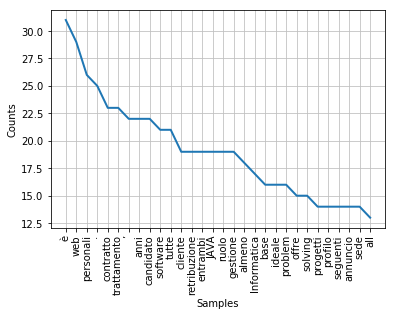

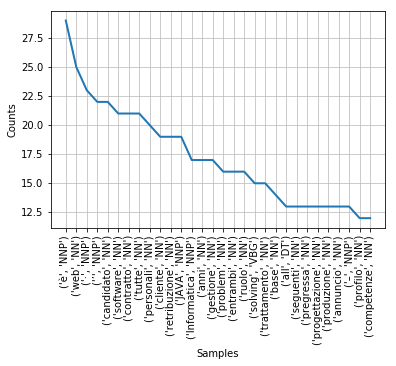

In [5]:
import nltk
import re
from bs4 import BeautifulSoup
import mechanicalsoup
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

stopwords_ita = ["é", "io", "noi", "voi", "il", "lo", "la", "i", "gli", "le", "di",
                 "in", "e", "and", "a", "per", "\\xc2\\xa0", "the", "del", "con", "della", "of", "to", "al", "o",
                 "ad", "ai", "-", "dei", "un", "delle", "si", "lavoro", "una", "che", "sensi", "with",
                 "ricerca", "ed", "nella", "alla", "la", "di", "si", "su", "is", "a", "nel", "sul", "da", "(bo)",
                 "e/o", "lingua", "for", "lavoro", "tempo", "\\xc3\\xa8", "buona", "azienda", "conoscenza",
                 "esperienza", "settore","team", "," , "'", ";", ".", ")", "(", ":", "bo", "bologna", "dati",
                 "https", "&", "richiede", "903/77", "candidati", "sviluppo", "@", "are", "sono", "sulla", 
                 "inviare", "degli", '77', '903', 'xa0', 'xa8', 'xc2', 'xc3', "/", "...", "'", "'", "`", "sessi", 
                 "13", "-", "_"]

df = pd.read_csv("data.csv")
df.info()

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words=stopwords_ita, tokenizer = token.tokenize)
text_counts= cv.fit_transform(df.data)

# print(text_counts)
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(
#    text_counts, data['Sentiment'], test_size=0.3, random_state=1)

print("\npreparing ...")
tokens = nltk.word_tokenize(ret)
clean_tokens = tokens[:]
for token in tokens:
    if token.lower() in stopwords_ita:
        clean_tokens.remove(token)

freq = nltk.FreqDist(clean_tokens)
print("plotting ...")
freq.plot(30, cumulative=False)

tag1 = nltk.pos_tag(clean_tokens)
freq = nltk.FreqDist(tag1)
freq.plot(30, cumulative=False)

#data=pd.read_csv('train.tsv', sep='\t')



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/cola/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True